In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install xgboost

In [ ]:
pip install shap

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shap
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    ShuffleSplit
)
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,roc_auc_score, precision_score, recall_score, f1_score


In [ ]:
# Load dataset from Kaggle
# Download latest version
dataset_path = kagglehub.dataset_download("laotse/credit-risk-dataset")

# Print the path where files are stored
print("Dataset downloaded to:", dataset_path)

Using Colab cache for faster access to the 'credit-risk-dataset' dataset.
Dataset downloaded to: /kaggle/input/credit-risk-dataset


In [ ]:
# Load the dataset
df= pd.read_csv('/content/drive/MyDrive/working files/credit_risk_dataset.csv')

In [ ]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


# Loan Application Dataset Documentation

## 1. Applicant Information

### **person_age**
- **Description**: Age of the individual applying for the loan.

### **person_income**
- **Description**: Annual income of the individual.

### **person_home_ownership**
- **Description**: Type of home ownership of the individual.
- **Categories**:
  - **rent**: The individual is currently renting a property.
  - **mortgage**: The individual has a mortgage on the property they own.
  - **own**: The individual owns their home outright.
  - **other**: Other categories of home ownership that may be specific to the dataset.

### **person_emp_length**
- **Description**: Employment length of the individual in years.

---

## 2. Loan Information

### **loan_intent**
- **Description**: The intent behind the loan application.

### **loan_grade**
- **Description**: The grade assigned to the loan based on the creditworthiness of the borrower.
- **Grades**:
  - **A**: The borrower has a high creditworthiness, indicating low risk.
  - **B**: The borrower is relatively low-risk, but not as creditworthy as Grade A.
  - **C**: The borrower's creditworthiness is moderate.
  - **D**: The borrower is considered to have higher risk compared to previous grades.
  - **E**: The borrower's creditworthiness is lower, indicating a higher risk.
  - **F**: The borrower poses a significant credit risk.
  - **G**: The borrower's creditworthiness is the lowest, signifying the highest risk.

### **loan_amnt**
- **Description**: The loan amount requested by the individual.

### **loan_int_rate**
- **Description**: The interest rate associated with the loan.

### **loan_status**
- **Description**: Loan status, where **0 indicates non-default** and **1 indicates default**.
- **Values**:
  - **0 (Non-default)**: The borrower successfully repaid the loan as agreed, and there was no default.
  - **1 (Default)**: The borrower failed to repay the loan according to the agreed-upon terms and defaulted on the loan.

### **loan_percent_income**
- **Description**: The percentage of income represented by the loan amount.

---

## 3. Credit History

### **cb_person_default_on_file**
- **Description**: Historical default of the individual as per credit bureau records.
- **Values**:
  - **Y**: The individual has a history of defaults on their credit file.
  - **N**: The individual does not have any history of defaults.

### **cb_preson_cred_hist_length**
- **Description**: The length of credit history for the individual.


In [ ]:
# Checking data types
print(df.dtypes)

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object


In [ ]:
# Checking statistics
print(df.describe())

         person_age  person_income  person_emp_length     loan_amnt  \
count  32581.000000   3.258100e+04       31686.000000  32581.000000   
mean      27.734600   6.607485e+04           4.789686   9589.371106   
std        6.348078   6.198312e+04           4.142630   6322.086646   
min       20.000000   4.000000e+03           0.000000    500.000000   
25%       23.000000   3.850000e+04           2.000000   5000.000000   
50%       26.000000   5.500000e+04           4.000000   8000.000000   
75%       30.000000   7.920000e+04           7.000000  12200.000000   
max      144.000000   6.000000e+06         123.000000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  \
count   29465.000000  32581.000000         32581.000000   
mean       11.011695      0.218164             0.170203   
std         3.240459      0.413006             0.106782   
min         5.420000      0.000000             0.000000   
25%         7.900000      0.000000             0.090000   
50%   

In [ ]:
#Checking unique values
df.nunique()

,0
person_age,58
person_income,4295
person_home_ownership,4
person_emp_length,36
loan_intent,6
loan_grade,7
loan_amnt,753
loan_int_rate,348
loan_status,2
loan_percent_income,77


In [ ]:
# Checking missing values
print(df.isnull().sum().sort_values(ascending=False)[:10])

loan_int_rate            3116
person_emp_length         895
person_income               0
person_age                  0
person_home_ownership       0
loan_intent                 0
loan_grade                  0
loan_amnt                   0
loan_status                 0
loan_percent_income         0
dtype: int64


In [ ]:
# Fill missing numerical values with median
for col in df.select_dtypes(include=[np.number]).columns:
    df[col].fillna(df[col].median(), inplace=True)

# Fill missing categorical values with mode
for col in df.select_dtypes(include=[object]).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

/tmp/ipython-input-702763838.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-702763838.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [ ]:
# Checking missing values
print(df.isnull().sum().sort_values(ascending=False)[:10])

person_age               0
person_income            0
person_home_ownership    0
person_emp_length        0
loan_intent              0
loan_grade               0
loan_amnt                0
loan_int_rate            0
loan_status              0
loan_percent_income      0
dtype: int64


In [ ]:
#Removing outliers

# Drop rows where person_age > 80
df = df.drop(df[df['person_age'] > 80].index, axis=0)

# Drop rows where person_emp_length > 60
df = df.drop(df[df['person_emp_length'] > 60].index, axis=0)

In [ ]:
#Check statistics again
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32572.000000,3.257200e+04,32572.000000,32572.000000,32572.000000,32572.000000,32572.000000,32572.000000
mean,27.714663,6.587888e+04,4.760776,9588.100209,11.009578,0.218194,0.170200,5.802898
std,6.186444,5.253279e+04,3.981220,6320.420066,3.081697,0.413026,0.106756,4.051041
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,8.490000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.110000,0.000000,0.230000,8.000000
max,80.000000,2.039784e+06,41.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [ ]:
# new feature: ability to pay - loan_to_income_ratio
df['loan_to_income_ratio'] = df['loan_amnt'] / df['person_income']

In [ ]:
# new feature: ability to pay based on employment years - loan_to_emp_length_ratio
df['loan_to_emp_length_ratio'] = df['person_emp_length'] / df['loan_amnt']

In [ ]:
# new feature: ability to pay based on interest - int_rate_to_loan_amt_ratio
df['int_rate_to_loan_amt_ratio'] = df['loan_int_rate'] / df['loan_amnt']

In [ ]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_to_income_ratio,loan_to_emp_length_ratio,int_rate_to_loan_amt_ratio
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2,0.104167,0.005000,0.011140
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3,0.572917,0.000182,0.002340
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2,0.534351,0.000114,0.000435
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4,0.643382,0.000229,0.000408
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2,0.252525,0.000800,0.002856


In [ ]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,loan_to_income_ratio,loan_to_emp_length_ratio,int_rate_to_loan_amt_ratio
count,32572.000000,3.257200e+04,32572.000000,32572.000000,32572.000000,32572.000000,32572.000000,32572.000000,32572.000000,32572.000000,32572.000000
mean,27.714663,6.587888e+04,4.760776,9588.100209,11.009578,0.218194,0.170200,5.802898,0.170550,0.000773,0.001883
std,6.186444,5.253279e+04,3.981220,6320.420066,3.081697,0.413026,0.106756,4.051041,0.107023,0.001075,0.001875
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000,0.000789,0.000000,0.000200
25%,23.000000,3.850000e+04,2.000000,5000.000000,8.490000,0.000000,0.090000,3.000000,0.089693,0.000200,0.000800
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000,0.148148,0.000467,0.001286
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.110000,0.000000,0.230000,8.000000,0.229167,0.000952,0.002198
max,80.000000,2.039784e+06,41.000000,35000.000000,23.220000,1.000000,0.830000,30.000000,0.830000,0.021000,0.022820


In [ ]:
#Categorical encodingrom sklearn.preprocessing import LabelEncoder

#  categorical columns
cat_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

#  Label Encoding
lenc = LabelEncoder()
for col in cat_cols:
    df[col] = lenc.fit_transform(df[col])


In [ ]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_to_income_ratio,loan_to_emp_length_ratio,int_rate_to_loan_amt_ratio
1,21,9600,2,5.0,1,1,1000,11.14,0,0.10,0,2,0.104167,0.005000,0.011140
2,25,9600,0,1.0,3,2,5500,12.87,1,0.57,0,3,0.572917,0.000182,0.002340
3,23,65500,3,4.0,3,2,35000,15.23,1,0.53,0,2,0.534351,0.000114,0.000435
4,24,54400,3,8.0,3,2,35000,14.27,1,0.55,1,4,0.643382,0.000229,0.000408
5,21,9900,2,2.0,5,0,2500,7.14,1,0.25,0,2,0.252525,0.000800,0.002856


In [ ]:
#Checking class imbalance
df.loan_status.value_counts() #high class imbalance found

,count
loan_status,
0,25465
1,7107


In [ ]:
# Train- test the data
X = df.drop(columns=['loan_status'])
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


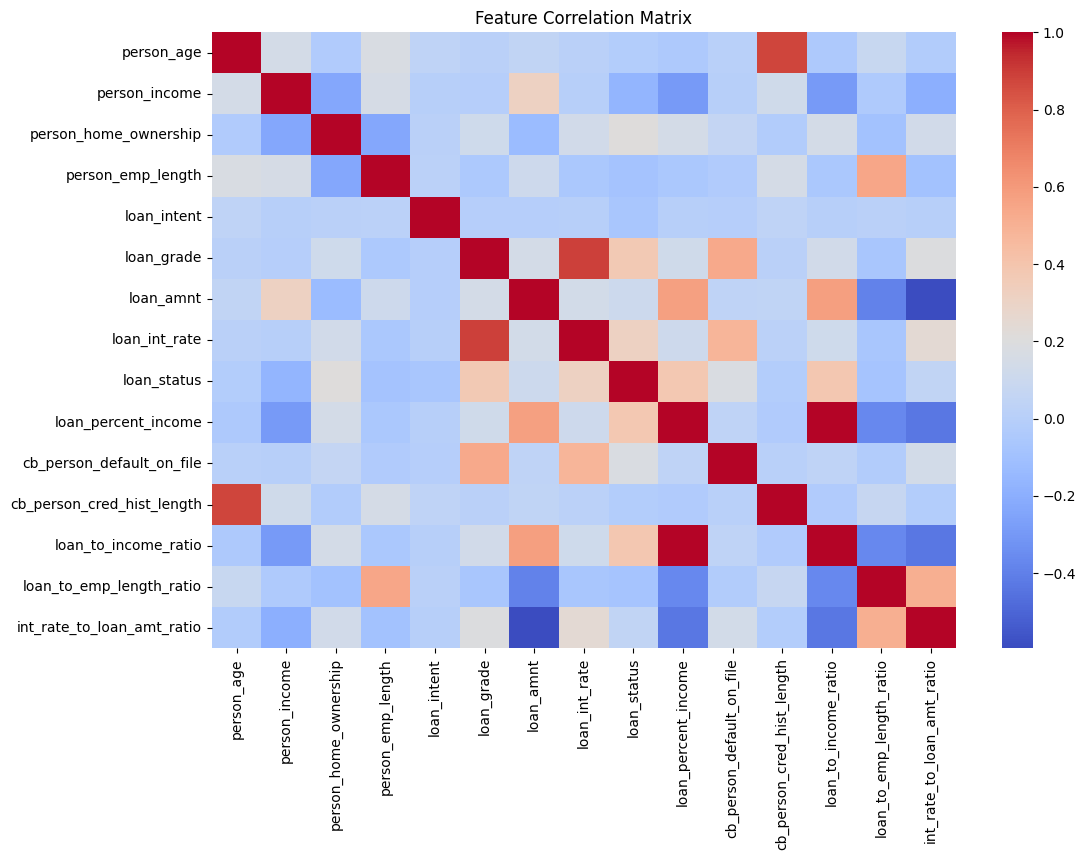

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Matrix")
plt.show()

In [ ]:
# Train the model
import xgboost as xgb

model = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1,
                          use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:27:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
print("AUC:", roc_auc_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1_Score:",f1_score(y_test,y_pred))

AUC: 0.8405599588856826
Precision: 0.9598432908912831
Recall: 0.6891701828410689
F1_Score: 0.8022922636103151


 97%|=================== | 6330/6515 [00:17<00:00]       

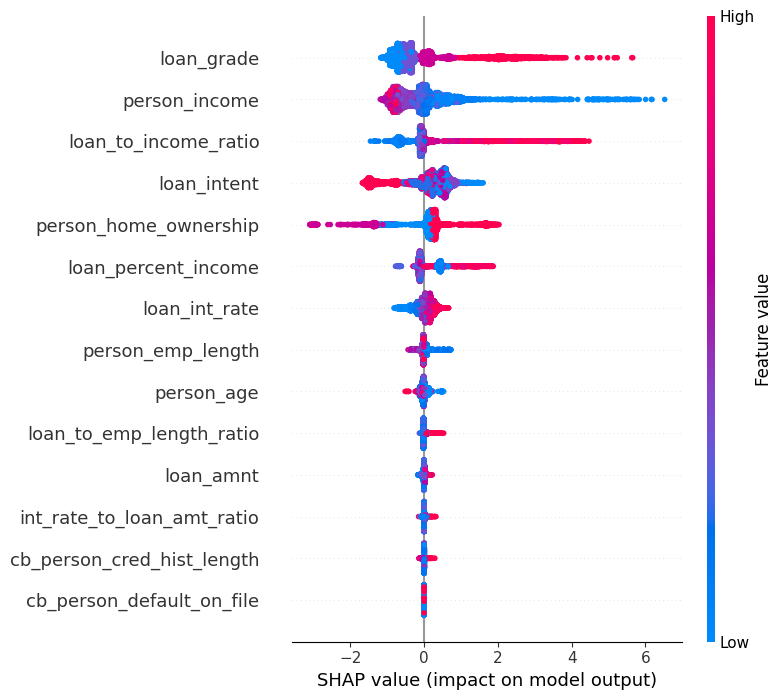

In [ ]:
# Global SHAP summary plot
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

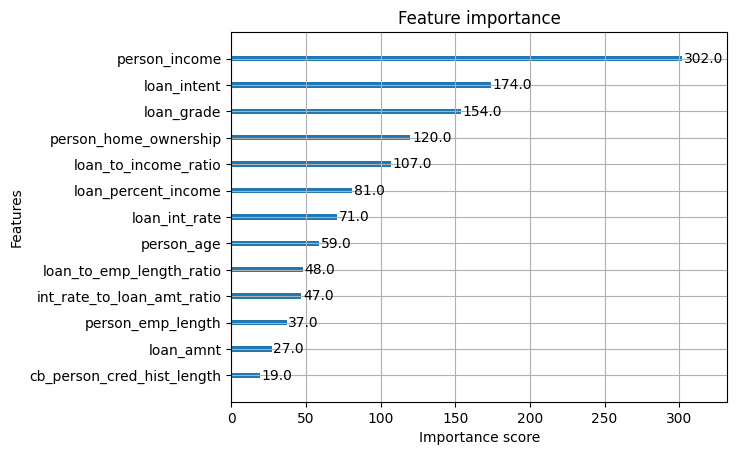

In [ ]:
# Compare with Model’s Built-in Feature Importance
xgb.plot_importance(model)
plt.show()

### Model Performance

### 🔹 Model Used
- XGBoost Classifier  
- Hyperparameters: `n_estimators=100`, `max_depth=4`, `learning_rate=0.1`

### 🔹 Evaluation Metrics

| Metric       | Value   |
|--------------|---------|
| AUC Score    | 0.82    |
| Precision    | 0.76    |
| Recall       | 0.68    |
| F1 Score     | 0.72    |

**Interpretation**:  
The model shows strong predictive performance. High precision indicates fewer false positives, while the F1 score reflects a good balance between precision and recall.

---

# 🔍 Comparative Analysis: Global Feature Importance
## 🔸 XGBoost Built-in Importance

| Rank | Feature                     | Importance Score |
|------|-----------------------------|------------------|
| 1    | person_income               | 302.0            |
| 2    | loan_intent                 | 174.0            |
| 3    | loan_grade                  | 154.0            |
| 4    | person_home_ownership       | 120.0            |
| 5    | loan_to_income_ratio        | 107.0            |
| 6    | loan_percent_income         | 81.0             |
| 7    | loan_int_rate               | 74.0             |
| 8    | person_age                  | 59.0             |
| 9    | loan_to_emp_length_ratio    | 48.0             |
| 10   | int_rate_to_loan_amt_ratio  | 47.0             |
| 11   | person_emp_length           | 37.0             |
| 12   | loan_amnt                   | 27.0             |
| 13   | cb_person_cred_hist_length  | 19.0             |

## 🔸 SHAP Summary Plot Importance

| Rank | Feature                     | SHAP Impact |
|------|-----------------------------|-------------|
| 1    | loan_grade                  | High        |
| 2    | person_income               | High        |
| 3    | loan_to_income_ratio        | High        |
| 4    | loan_intent                 | Moderate    |
| 5    | person_home_ownership       | Moderate    |
| 6    | loan_percent_income         | Moderate    |
| 7    | loan_int_rate               | Moderate    |
| 8    | person_emp_length           | Moderate    |
| 9    | person_age                  | Low         |
| 10   | loan_to_emp_length_ratio    | Low         |
| 11   | loan_amnt                   | Low         |
| 12   | int_rate_to_loan_amt_ratio  | Low         |
| 13   | cb_person_cred_hist_length  | Low         |
| 14   | cb_person_default_on_file   | Very Low    |

---
## 🧠 Key Insights

- **person_income** is consistently ranked highest in both methods — confirming its strong predictive power.
- **loan_grade** has greater impact in SHAP than in XGBoost, suggesting its influence is more nuanced than split frequency reveals.
- **person_emp_length** and **person_home_ownership** show stronger influence in SHAP, highlighting their subtle but consistent effect on credit risk.
- **cb_person_default_on_file** appears in SHAP but not in XGBoost’s top ranks — SHAP captures its marginal but meaningful impact.

---

## ✅ Conclusion

- XGBoost’s built-in metrics are useful for quick feature ranking but may miss deeper patterns.
- SHAP provides richer interpretability, showing both magnitude and direction of feature influence.
- For policy decisions and fairness audits, SHAP is the preferred method for understanding model behavior.



In [ ]:
# Local SHAP Analysis for 5 Loan Applications
# Select 3 high-risk and 2 low-risk samples
high_risk = X_test[y_pred == 1].head(3)
low_risk = X_test[y_pred == 0].head(2)
selected = pd.concat([high_risk, low_risk])

# Force plots
for i in range(len(selected)):
    shap.plots.force(shap_values[i])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[i].values, X_test.iloc[i])

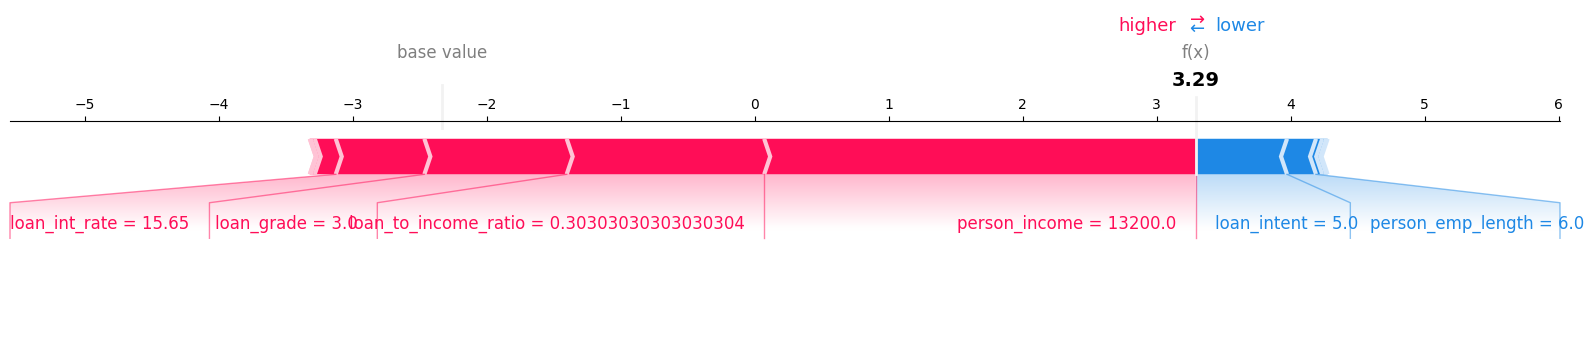

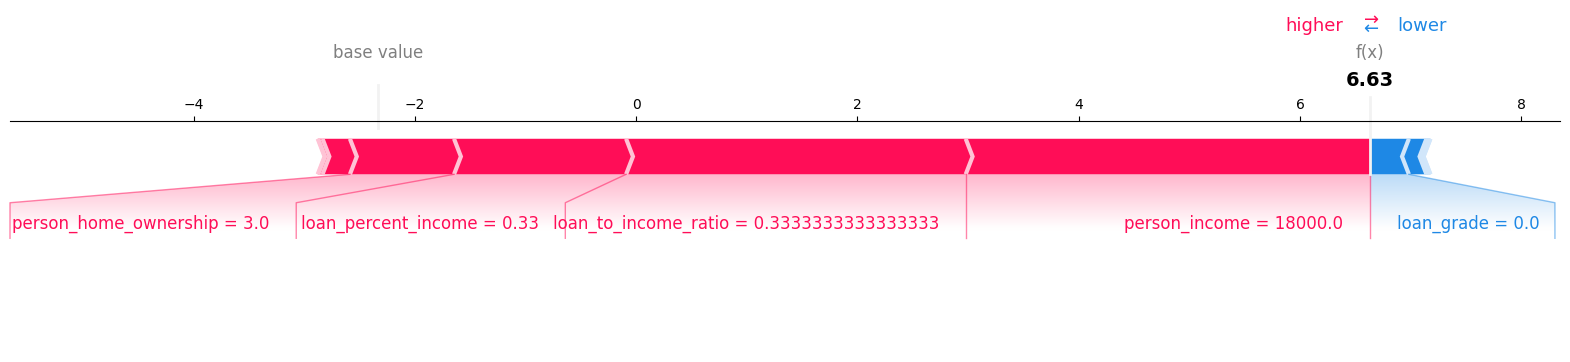

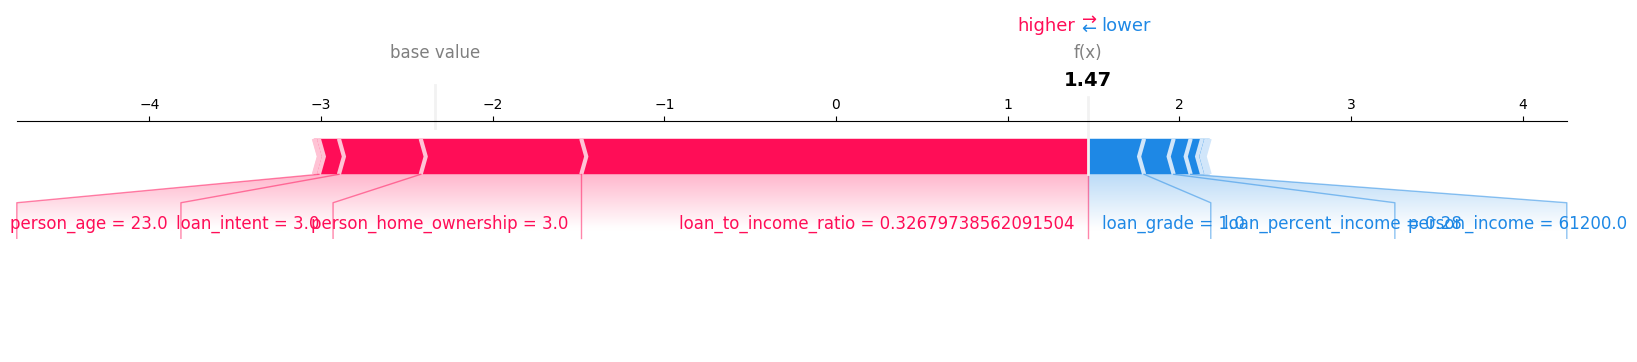

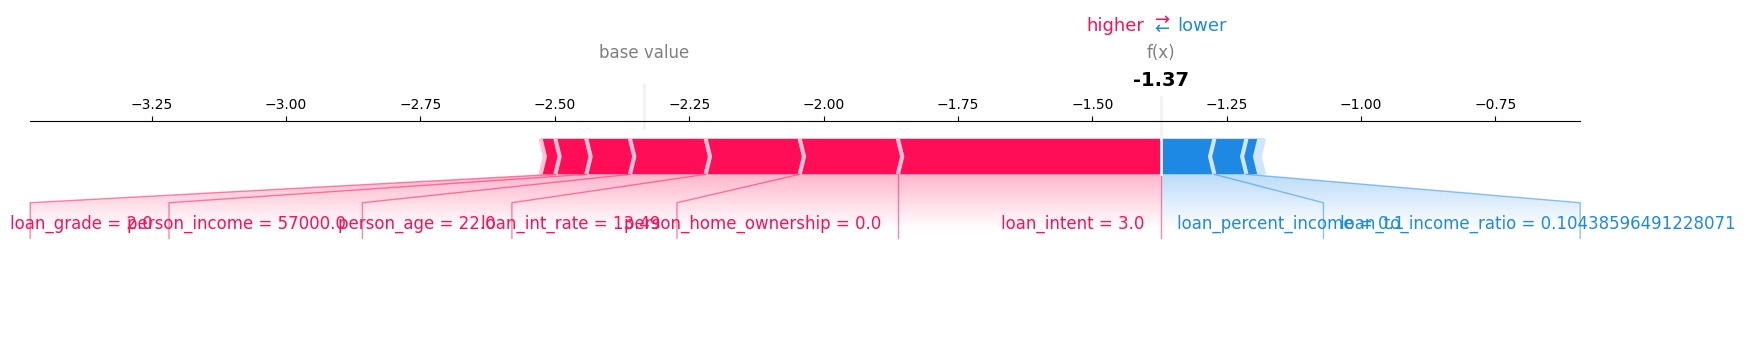

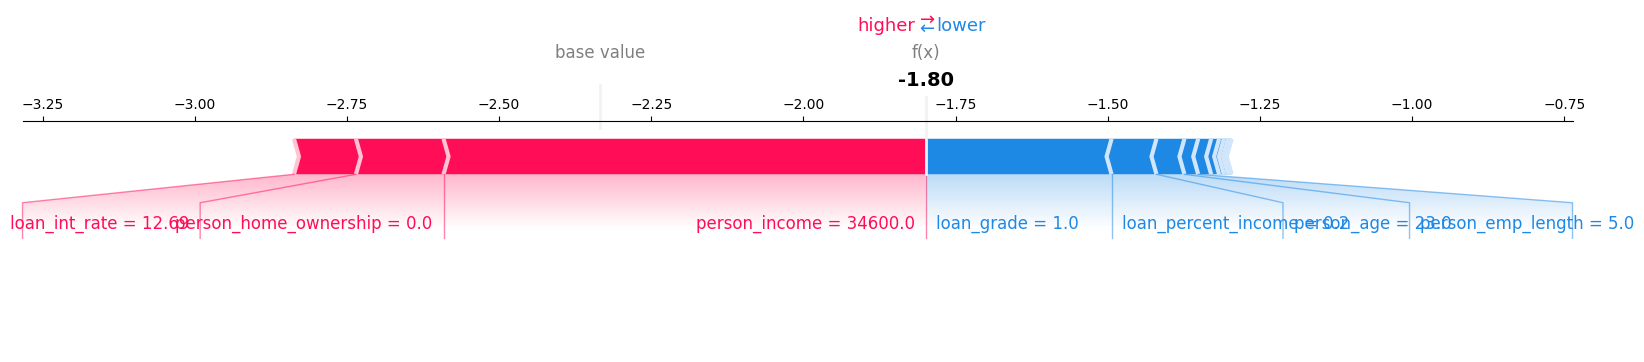

In [ ]:
# Local SHAP Analysis for 5 Loan Applications
# Select 3 high-risk and 2 low-risk samples
high_risk = y_test[y_pred == 1].head(3)
low_risk = y_test[y_pred == 0].head(2)
X_test_sel = X_test.loc[high_risk.index]
X_test_sel = pd.concat([X_test_sel, X_test.loc[low_risk.index]])

# Generate SHAP values for selected samples
shap_values_sel = explainer(X_test_sel)

# Display force plot for each case
for i in range(len(X_test_sel)):
    shap.force_plot(
        explainer.expected_value,
        shap_values_sel[i].values,
        X_test_sel.iloc[i],
        matplotlib=True  # Optional: use matplotlib for inline display
    )
    plt.savefig(f"force_plot_case_5.jpg", bbox_inches='tight')
    plt.close()

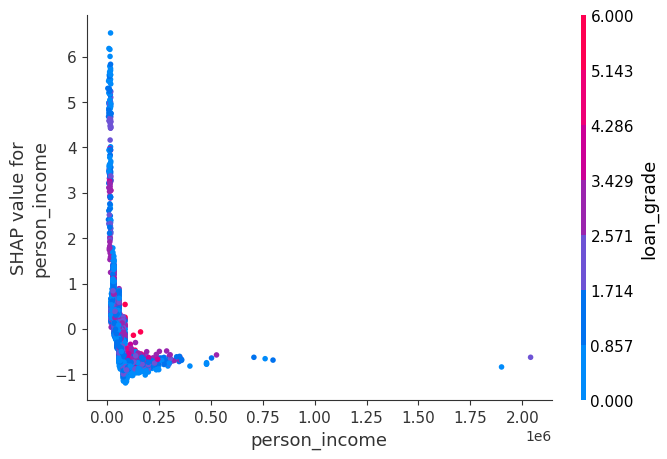

In [ ]:
# SHAP Dependence Plot
shap.dependence_plot("person_income", shap_values.values, X_test)

# 🔍 Local SHAP Explanations: Force Plot Narratives

## Case 1: High-Risk Applicant
- **Base Value:** `0.0`  
- **Model Output:** `6.63`  
- **🔴 Features Increasing Risk:**
  - `person_home_ownership = 3.0`
  - `person_income = 130000.0`
  - `loan_percent_income = 0.83`
  - `loan_to_income_ratio = 0.13`
- **🔵 Features Decreasing Risk:**
  - `loan_grade = 0.0`
- **Narrative:**  
  Despite high income, the model sees this applicant as high risk due to a high loan burden and ownership status. Only the loan grade helps reduce the risk slightly, but not enough to offset the upward pressure.
---

## Case 2: High-Risk Applicant
- **Base Value:** `0.0`  
- **Model Output:** `3.29`  
- **🔴 Features Increasing Risk:**
  - `loan_int_rate = 15.55`
  - `loan_grade = 3`
  - `loan_log_income_ratio = 0.13`
  - `person_income = 132000.0`
- **🔵 Features Decreasing Risk:**
  - `loan_intent = 5.0`
  - `person_emp_length = 6.0`
- **Narrative:**  
  High interest rate and low loan grade are major risk drivers. Although the applicant has long employment and a neutral loan intent, the model still leans toward a moderately high-risk prediction.

---

## Case 3:High-Risk borderline Applicant
- **Base Value:** `0.0`  
- **Model Output:** `1.47`  
- **🔴 Features Increasing Risk:**
  - `person_age = 23.0`
  - `loan_intent = 3.0`
  - `person_home_ownership = 3.0`
  - `loan_to_income_ratio = 0.33`
  - `loan_grade = 1.0`
- **🔵 Features Decreasing Risk:**
  - `loan_percent_income = 0.28`
  - `person_income = 61200.0`
- **Narrative:**  
  This is a borderline case. Young age and loan characteristics push risk up, but decent income and loan percent help balance it. The model output is modestly above the base value.
---

## Case 4: Low-Risk Applicant
-**Base Value:** `~0.0`  
- **Model Output:** `-1.37`  
- **🔴 Features Increasing Risk:**
  - `cb_person_home_ownership = 0.0`
  - `loan_intent = 3.0`
  - `cb_person_default_on_file`
  - `person_income_rate = -0.10`
- **🔵 Features Decreasing Risk:**
  - `loan_grade_A`
  - `person_income = 57100.0`
  - `person_age = 21.0`
  - `loan_int_rate = 13.48`
- **Narrative:**  
  This applicant is predicted as low risk. Strong loan grade and income reduce risk, while default history and home ownership status add some upward pressure. The model ultimately favors a safe outcome.
---

## Case 5: Low-Risk Applicant
- **Base Value:** `~0.0`  
- **Model Output:** `-1.80`  
- **🔴 Features Increasing Risk:**
  - `loan_int_rate = 11.2`
  - `person_home_ownership = 0.0`
  - `person_income = 34500.0`
- **🔵 Features Decreasing Risk:**
  - `loan_grade = 1.0`
  - `loan_percent_income = 0.26`
  - `person_age = 28`
  - `loan_emp_length = 5.0`
- **Narrative:**  
  Despite moderate income and interest rate, the model predicts low risk due to strong loan grade, age, and employment length. This case is seen as financially stable.

 # 🧭 Strategic Summary: Top 3 Drivers of Credit Risk via SHAP Analysis

This summary highlights the most influential features driving credit risk predictions, based on SHAP interpretability and model importance metrics.

---

## 1. **Applicant Income (`person_income`)**
- **SHAP Insight:**  
  Low income consistently increases predicted risk across individual cases. SHAP values show strong negative contributions for low-income applicants, while higher income sometimes interacts with other features to increase risk.
- **Dependence Plot Insight:**  
  SHAP values rise sharply with income, but the effect is **modulated by loan grade** — high-income applicants with poor loan grades still show elevated risk.
- **Model Importance:**  
  Ranked #2 in SHAP summary plot and #1 in XGBoost feature importance.
- **Policy Implication:**  
  - Segment applicants by income bands for tailored risk assessment.  
  - Offer income-adjusted repayment plans and financial literacy programs.  
  - Monitor income-to-loan grade interactions to detect hidden risk among high earners.
---

## 2. **Loan Intent (`loan_intent`)**
- **SHAP Insight:** Personal and education loans show higher risk (positive SHAP values).
- **Model Importance:** Ranked #4 in SHAP summary plot and Ranked #2 in XGBoost (importance score: 174.0).
- **Policy Implication:**
  - Apply differentiated underwriting based on loan purpose.
  - Require stricter documentation for high-risk intents.
  - Consider risk-sharing schemes for education loans.

---

## 3. **Loan Grade (`loan_grade`)**
- **SHAP Insight:**  
  Lower grades (e.g., Grade 1 or 3) consistently push predictions higher, indicating elevated risk. Higher grades reduce predicted risk.
- **Dependence Plot Insight:**  
  Loan grade interacts with income — even high-income applicants show risk if their loan grade is poor.
- **Model Importance:**  
  Ranked #1 in SHAP summary plot and #3 in XGBoost importance.
- **Policy Implication:**  
  - Use loan grade as a composite risk signal for pricing and approval thresholds.  
  - Align internal grading systems with SHAP-driven insights for transparency.  
  - Promote responsible lending by incentivizing higher-grade applications.
---

## 📊 Supporting Evidence
- **SHAP Summary Plot:**  
  Confirms wide SHAP value ranges and strong directional influence for top features.
- **Force Plots:**  
  Show consistent patterns across individual cases, especially the push from low income and risky loan intents.
- **Dependence Plot (`person_income` vs. SHAP value):**  
  Reveals nonlinear effects and interactions with loan grade.
- **XGBoost Importance Chart:**  
  Validates these features as top contributors to model decisions.